![iNeuron Logo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTRLLj3Vw3ASLxRes0gT0QysvPrQ2Vy3uSC4IAWEjb3&s)

# Finance Complaint Project

## Feature Engineering and Model Training 

**Import required libraries**

In [2]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For Classification model selection
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# For data pre-processing
from sklearn.preprocessing import OneHotEncoder,StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders.binary import BinaryEncoder
from imblearn.combine import SMOTETomek

# For Hyperparameter tuning
from hyperopt import tpe,hp,Trials,space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

**Import the data from source**

In [3]:
df = pd.read_parquet('data/finance.parquet')

### As per Final report of EDA some features can be removed 

In [5]:
missing = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing[0:8]

,0
tags,85.884302
company_public_response,74.461999
sub_issue,59.124530
sub_product,30.542196
state,0.736007
zip_code,0.735616
consumer_consent_provided,0.004950
product,0.000000


**Company column can be dropped as it contains 4284 unique values which are names**

In [6]:
drop_columns = ['tags','complaint_what_happened','company_public_response',
                'sub_issue','sub_product','zip_code','complaint_id', 'company']
df.drop(drop_columns, axis=1, inplace=True)

In [37]:
missing = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing

,0
state,0.736007
consumer_consent_provided,0.004950
company_response,0.000000
consumer_disputed,0.000000
date_received,0.000000
date_sent_to_company,0.000000
issue,0.000000
product,0.000000
submitted_via,0.000000
timely,0.000000


- In `state` and `consumer_consent_provided` only 0.7 and 0.04 % of missing values. it can be imputed with Simple imputer with mode strategy 

## Feature Extraction

In [7]:
df[['date_received','date_sent_to_company']].head(3)

,date_received,date_sent_to_company
0,2017-04-05T12:00:00-05:00,2017-04-05T12:00:00-05:00
1,2017-04-07T12:00:00-05:00,2017-04-07T12:00:00-05:00
2,2017-04-07T12:00:00-05:00,2017-04-07T12:00:00-05:00


- Here dataset has two date feature, `date_received` which is the the date on which the complaint was registered to CFPB and `date_sent_to_company` is when the complaint has been sent the respective company.   

In [9]:
# difference between date complaint received vs data complaint sent to the company
df['days_to_forward_complaint']=pd.to_datetime(df.date_sent_to_company)-pd.to_datetime(df.date_received)

# Get the days in datetime days (numeric) format
df['days_to_forward_complaint']= df['days_to_forward_complaint'].dt.days

In [40]:
# After creating the days_to_forward_complaint, both the date columns can be removed 
df.drop(['date_sent_to_company','date_received'], axis=1, inplace=True)

The feature days to forward complaint has information about the duration taken for CFPB to forward the complaint to companies

### For model to reduce computation time we can use sample of the data for model

In [16]:
# Get a sample data to perform model training

df1 = df.groupby("consumer_disputed").sample(n=50000)
df1.reset_index(inplace=True)

## Text Processing

**For Vectorization**

* TFIDF
* CountVectorizer
* NLTK/Scipy Library
* Pretrained Glove

- here we can use TFIDF to process

**Steps for text processing**

*   Remove Punctuation
*   Remove Stop words
*   Lower Casing
*   Tokenization
*   Stemmig/Lemmatization

- `issue` column has text which has to be preprocessed.
- The text needs to be transformed into vectors so as the algorithms will be able to make predictions. In this case, it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.
- After removing punctuation and lower casing the words, the importance of a word is determined in terms of its frequency.

**Create list of stop words which has to be removed**

In [12]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

**Create Function to tokenize and lematize the text column**

In [19]:
# function to tokenize data and remove stopwords
def process_text(issue):
    
    #create tokens
    tokens = nltk.word_tokenize(issue)
    
    # remove common stopwords
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
    # remove stopwords including few punctuation
    stopwords_removed = [word for word in stopwords_removed if word.isalpha()]
    return stopwords_removed


# concant the strings
def concat_strings(words_list):
    concat_words = ''
    for word in words_list:
        concat_words += word + ' '
    return concat_words.strip()


# function to lemmatize words and merge each complaint into a single space-separated string
lemm = WordNetLemmatizer()

def lemmatizer_concat(words_list):
    # remove any NaN's
    list_of_words = [i for i in words_list if i is not np.nan]
    
    # lemmatize each word
    lemmatized_list = []
    for idx, word in enumerate(words_list):
        lemmatized_list.append(lemm.lemmatize(word))
    
    # make the list into a single string with the words separated by ' '
    final_string = concat_strings(lemmatized_list)
    return final_string

**Prepare data with text processing**

In [22]:
for i in range(len(df1)):
    text = process_text(df1['issue'].loc[i])
    final_texts = lemmatizer_concat(text)
    df1['issue'].loc[i] = final_texts
    if i % 5000 == 0:
        print(f'Processed Row Number {i}')

Processed Row Number 0
Processed Row Number 5000
Processed Row Number 10000
Processed Row Number 15000
Processed Row Number 20000
Processed Row Number 25000
Processed Row Number 30000
Processed Row Number 35000
Processed Row Number 40000
Processed Row Number 45000
Processed Row Number 50000
Processed Row Number 55000
Processed Row Number 60000
Processed Row Number 65000
Processed Row Number 70000
Processed Row Number 75000
Processed Row Number 80000
Processed Row Number 85000
Processed Row Number 90000
Processed Row Number 95000


**Vectorizing the processed texts**

In [25]:
tfidv = TfidfVectorizer(max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1, 2))

# Get data after vectorizing issue column
df_vect = tfidv.fit_transform(df1['issue'])

feature_names = tfidv.get_feature_names()

# Data Preprocessing

**Concat old data with vectorized data from issue text column**

In [30]:
df1 =pd.concat([df1, pd.DataFrame(df_vect.toarray())], axis = 1)

**After processing issue column as vectors, Now issue column can be removed**

In [43]:
df1.drop(['issue', 'index'], axis=1, inplace=True)

In [185]:
from sklearn.model_selection import train_test_split
X = df1.drop(['consumer_disputed'], axis=1)
y = df1['consumer_disputed']

In [172]:
#check shape of Train data
X.shape

(100000, 321)

#### Initialize features for transformation 

In [157]:
# for binary encoder
binary_features = ['product', 'state', 'submitted_via', 'company_response']
# for onehot encoder
onhot_features = ['consumer_consent_provided', 'timely','state']

**Create columntrasnformer for transformation**

In [186]:
onehot_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('OneHot_encoder', OneHotEncoder())
])

binary_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('BinaryEncoder', BinaryEncoder())
])

# getting data pre processor object
preprocessor = ColumnTransformer(
    [
        ("Categorical_Pipeline", onehot_encoder_pipeline, onhot_features),
        ("Binary_encoder_pipeline", binary_encoder_pipeline, binary_features),
        ("Numeric_Pipeline", RobustScaler(), numerical_feature)
    ]
,remainder='passthrough'
)

**Transforming the data for modelling**

In [187]:
# fit transform the train data
X= preprocessor.fit_transform(X)

**Manually Encoding Target Feature**

In [189]:
# manually encoding "Yes" as 0 and "No" as 1 
y = np.where(y.values=="Yes", 0, 1)

## Handling Imbalanced Dataset
**Handling Imbalanced Target Variable.**

- Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

- SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

In [167]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Model Selection

**Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**


In [127]:
# Function which returns all evaluation metrics for classification model

def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [128]:
# Initialize models which are required for model selection

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [129]:
# Create a function which can evaluate models and return a report in Dataframe

def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), 
                        columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

### Base report of all models with default parameters

In [190]:
base_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 0.7742
- F1 score: 0.7642
- Precision: 0.7989
- Recall: 0.7324
- Roc Auc Score: 0.7742
----------------------------------
Model performance for Test set
- Accuracy: 0.5702
- F1 score: 0.5567
- Precision: 0.5772
- Recall: 0.5377
- Roc Auc Score: 0.5703


Decision Tree
Model performance for Training set
- Accuracy: 0.7743
- F1 score: 0.7511
- Precision: 0.8362
- Recall: 0.6817
- Roc Auc Score: 0.7742
----------------------------------
Model performance for Test set
- Accuracy: 0.5625
- F1 score: 0.5257
- Precision: 0.5766
- Recall: 0.4831
- Roc Auc Score: 0.5628


Gradient Boosting
Model performance for Training set
- Accuracy: 0.5910
- F1 score: 0.5411
- Precision: 0.6155
- Recall: 0.4828
- Roc Auc Score: 0.5909
----------------------------------
Model performance for Test set
- Accuracy: 0.5927
- F1 score: 0.5453
- Precision: 0.6202
- Recall: 0.4866
- Roc Auc Score: 0.5931


Logistic Regression
Model performance for Training 

### Report in DataFrame

In [191]:
base_report

,Model Name,Accuracy
6,CatBoosting Classifier,0.600750
5,XGBClassifier,0.597572
2,Gradient Boosting,0.592674
3,Logistic Regression,0.588505
7,AdaBoost Classifier,0.587515
0,Random Forest,0.570163
1,Decision Tree,0.562451
4,K-Neighbors Classifier,0.559533


**Here we can use CatBoost Classifier, XGBClassifier for Hyper Parameter Tuning**

## Hyperopt: Distributed Hyperparameter Optimization

- Hyperopt is a powerful python library for hyperparameter optimization developed by James Bergstra. Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model.
- Grid Search is exhaustive in case of Resources usage.
- Random Search, is random, so could miss the most important values. However, there is a superior method available through the Hyperopt package


**Search space is where Hyperopt really gives you a many of sampling options:**

- for categorical parameters you have hp.choice
- for integers you get hp.randit, hp.quniform, hp.qloguniform and hp.qlognormal
- for floats we have hp.normal, hp.uniform, hp.lognormal and hp.loguniform
- It is the most extensive sampling functionality out there.


You define your search space before you run optimization but you can create very complex parameter spaces:

### Hyperparamter tuning for Xgboost Model

**This is a function to minimize that receives hyperparameters values as input from the search space and returns the loss**



In [197]:
# Create an objective function for hyperopt
def XGB_objective(params):
    model = XGBClassifier(**params, n_jobs =-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return -acc

In [200]:
# Define the seacrh space

search_space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

xgb_trials = Trials()

# Using Fmin function to get best xgb_objective
best_xgb= fmin(
    fn=XGB_objective,
    space=search_space,
    algo=tpe.suggest,
    trials=xgb_trials,
    max_evals=10,
    rstate=np.random.default_rng()
)

100%|████████████████████████████████████████████████| 10/10 [16:26<00:00, 98.65s/trial, best loss: -0.593559481006722]


* **Xgboost Classifier has accuracy of 59.35%**

### HyperParamter tuning for Catboost model

In [202]:
def CatBoost_objective(params):
    model = CatBoostClassifier(**params,verbose=False, thread_count=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return -acc

In [235]:
search_space = {
        'learning_rate': hp.uniform('learning_rate', 0.001, 1),
        'depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
        'iterations': scope.int(hp.quniform('iterations', 50,1000,50)),
        'l2_leaf_reg': scope.int(hp.quniform('l2_leaf_reg',1,50,1))
}

cat_trials = Trials()

# Using Fmin function to get best rf_objective
best_cat= fmin(
    fn=CatBoost_objective,
    space=search_space,
    algo=tpe.suggest,
    trials=cat_trials,
    max_evals=10,
    rstate=np.random.default_rng()
)

100%|███████████████████████████████████████████████| 10/10 [02:07<00:00, 12.73s/trial, best loss: -0.6027825543223386]


**Best parameters for catboost model**

In [236]:
best_cat

{'iterations': 500.0,
 'l2_leaf_reg': 34.0,
 'learning_rate': 0.08499842096744226,
 'max_depth': 8.0}

## Final Model

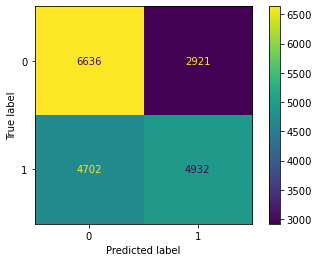

In [238]:
model = CatBoostClassifier(**best_cat, verbose=False, thread_count=-1)

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

matrix =confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(matrix)

### Confusion matrix for the Final Catboost model

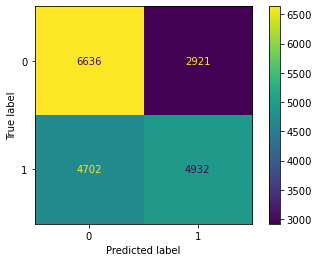

In [239]:
cm.plot();

## The Best model is Catboost Classifier with 60.27% Accuracy

In [ ]:
## - Note accuracy may vary on different runs as we take random sample from the data for model training